In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from lifelines.utils import concordance_index
import numpy as np
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings("ignore")
cancer_data = pd.read_csv("Breast_cancer.csv")

In [2]:
cancer_data.shape

(4024, 16)

In [3]:
cancer_data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [4]:
cancer_data["Status"].value_counts()

Alive    3408
Dead      616
Name: Status, dtype: int64

In [5]:
cancer_data.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [6]:
## Data Quality is high we dont have any null values
cancer_data['Survival Months'].unique()

array([ 60,  62,  75,  84,  50,  89,  54,  14,  70,  92,  64,  56,  38,
        49, 105, 107,  77,  81,  78, 102,  98,  82,  86,  52,  90,  31,
        37, 103,  42,  61,  63,  39,  59,  71,  74,  73,  91, 106,  80,
        44,  85,  79, 104,  12,  95,  55, 101,  65,  72,  57,  87,  40,
        25,   8,  53,  58,  24,  66,  69,  93,  94, 100,  96,  41,  67,
        51,  13,  11,  47,  23,  45,  68,  76,  15,  16,  99,   7,  48,
        88,  34,  97,  83,  17,   3,  22,  30,   6,  32,   9,   5,  10,
        19,  18,  35,  27,  36,   4,  29,  33,  26,  20,  28,  43,   1,
        46,  21,   2], dtype=int64)

In [7]:
cancer_data['Status'].unique()

array(['Alive', 'Dead'], dtype=object)

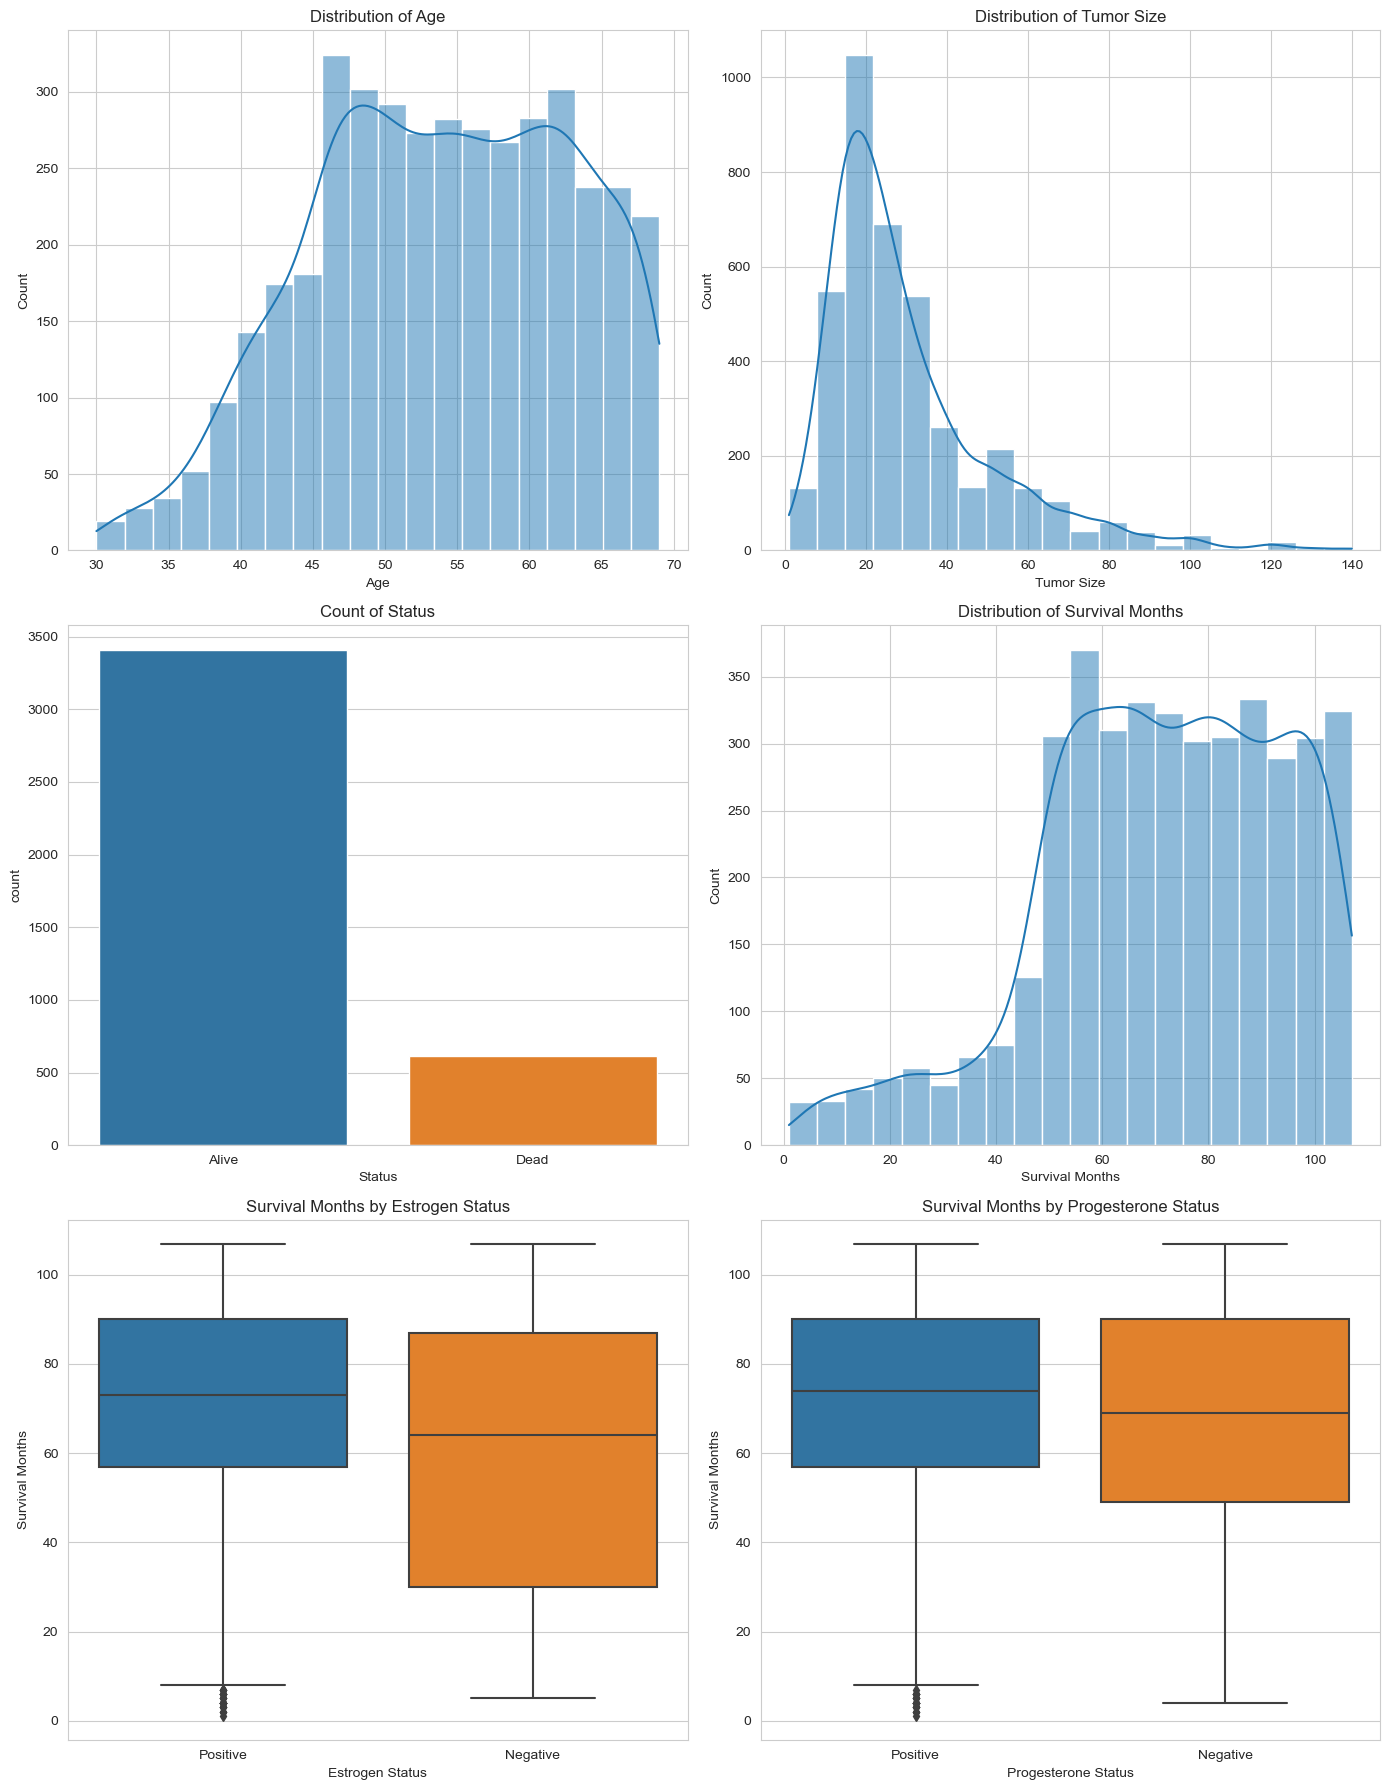

In [8]:
## EDA
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
sns.histplot(cancer_data['Age'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Age')

# Distribution of Tumor Size
sns.histplot(cancer_data['Tumor Size'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Tumor Size')

# Status counts
sns.countplot(x='Status', data=cancer_data, ax=axes[1, 0])
axes[1, 0].set_title('Count of Status')

# Distribution of Survival Months
sns.histplot(cancer_data['Survival Months'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Survival Months')

# Boxplot of Survival Months by Estrogen Status
sns.boxplot(x='Estrogen Status', y='Survival Months', data=cancer_data, ax=axes[2, 0])
axes[2, 0].set_title('Survival Months by Estrogen Status')

# Boxplot of Survival Months by Progesterone Status
sns.boxplot(x='Progesterone Status', y='Survival Months', data=cancer_data, ax=axes[2, 1])
axes[2, 1].set_title('Survival Months by Progesterone Status')

plt.tight_layout()
plt.show()

In [9]:
'''
INSIGHTS FROM EDA

Distribution of Age:
The age distribution appears roughly normal with a peak around the mid-50s. This suggests that the majority of the patients diagnosed with breast cancer in this dataset are in their mid-life, with fewer younger and older patients.
Distribution of Tumor Size:
The distribution is right-skewed, indicating that most tumors diagnosed are smaller in size, with fewer cases having very large tumors. The right skew suggests that while small tumors are more common, there are significant occurrences of large tumors that could potentially be more problematic.
Count of Status:
This plot shows that a large majority of patients in the dataset are alive. It would be important to understand what proportion of these patients are recently diagnosed versus long-term survivors to further contextualize these figures.
Distribution of Survival Months:
The survival months distribution is also right-skewed, which means most patients have a high survival rate in terms of months post-diagnosis. The tail extending towards the higher number of months indicates there are patients who live much longer after their initial diagnosis.
Survival Months by Estrogen Status:
The boxplot shows that patients with positive estrogen status tend to have a wider range and slightly higher median survival months compared to those with negative status. This could imply that estrogen-positive patients might respond better to certain therapies, or it might reflect different characteristics of the cancer type.'''

'\nINSIGHTS FROM EDA\n\nDistribution of Age:\nThe age distribution appears roughly normal with a peak around the mid-50s. This suggests that the majority of the patients diagnosed with breast cancer in this dataset are in their mid-life, with fewer younger and older patients.\nDistribution of Tumor Size:\nThe distribution is right-skewed, indicating that most tumors diagnosed are smaller in size, with fewer cases having very large tumors. The right skew suggests that while small tumors are more common, there are significant occurrences of large tumors that could potentially be more problematic.\nCount of Status:\nThis plot shows that a large majority of patients in the dataset are alive. It would be important to understand what proportion of these patients are recently diagnosed versus long-term survivors to further contextualize these figures.\nDistribution of Survival Months:\nThe survival months distribution is also right-skewed, which means most patients have a high survival rate i

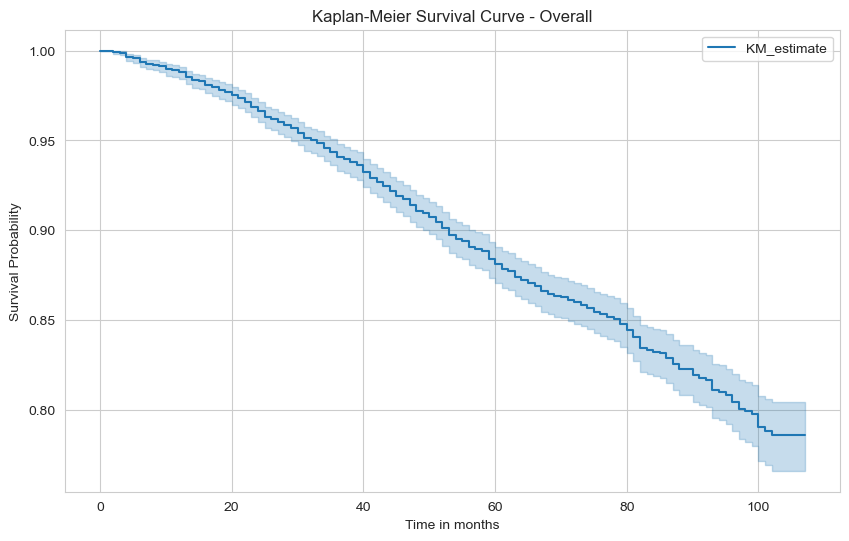

,KM_estimate
timeline,
0.0,1.000000
1.0,1.000000
2.0,0.999503
3.0,0.999006
4.0,0.996767


In [11]:
cancer_data_copy = cancer_data.copy()

cancer_data_copy['event_observed'] = cancer_data_copy['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
cancer_data_copy['Status'] = cancer_data_copy['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
kmf = KaplanMeierFitter()
kmf.fit(durations=cancer_data_copy["Survival Months"], event_observed=cancer_data_copy["Status"])

plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve - Overall')
plt.xlabel('Time in months')
plt.ylabel('Survival Probability')
plt.show()

kmf.survival_function_.head()


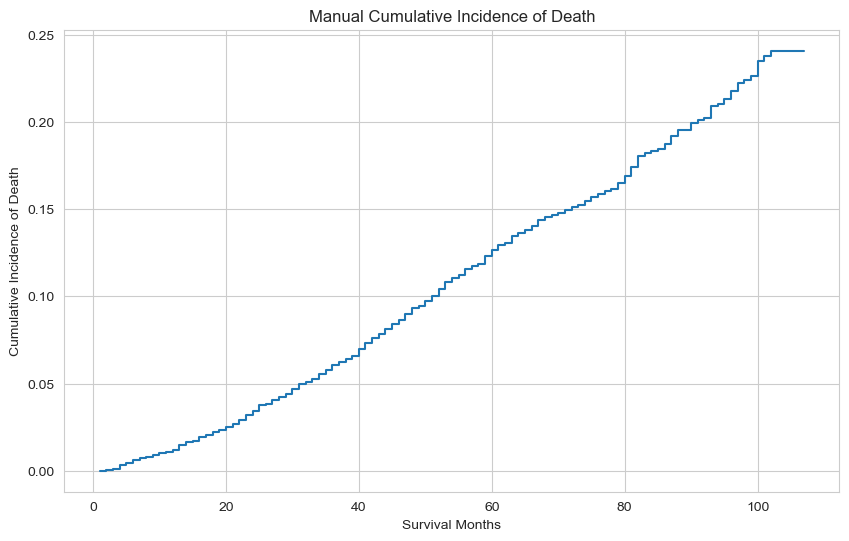

In [12]:
def manual_cumulative_incidence(data, time_col, event_col):
    data_sorted = data.sort_values(by=time_col)
    times = data_sorted[time_col]
    events = data_sorted[event_col]
    unique_times = np.unique(times)
    risk_set = np.array([len(data_sorted[data_sorted[time_col] >= t]) for t in unique_times])
    event_counts = np.array([np.sum(events[times == t]) for t in unique_times])
    
    incidence_rate = event_counts / risk_set
    cumulative_incidence = np.cumsum(incidence_rate)    
    
    return unique_times, cumulative_incidence

#cancer_data['event_observed'] = cancer_data['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

times, cumulative_incidence = manual_cumulative_incidence(cancer_data_copy, 'Survival Months', 'event_observed')
plt.figure(figsize=(10, 6))
plt.step(times, cumulative_incidence, where="post")
plt.title('Manual Cumulative Incidence of Death')
plt.xlabel('Survival Months')
plt.ylabel('Cumulative Incidence of Death')
plt.grid(True)
plt.show()

In [14]:
cancer_data["Grade"].unique()

array(['3', '2', '1', ' anaplastic; Grade IV'], dtype=object)

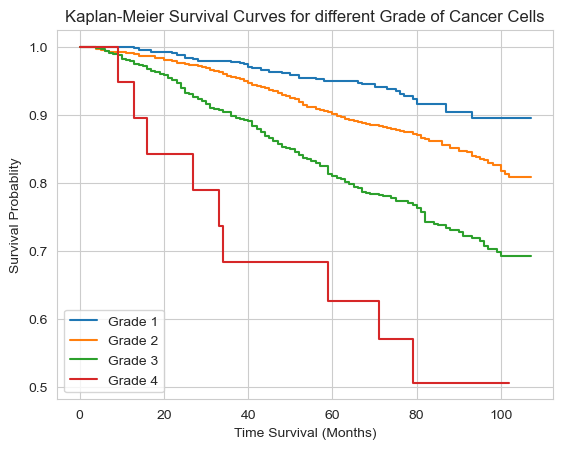

In [16]:
## KM estimate based on the Grade level of cancer cells

time = cancer_data_copy["Survival Months"]
event = cancer_data_copy["Status"]
grade_1 = (cancer_data_copy["Grade"] == "1")
grade_2 = (cancer_data_copy["Grade"] == "2")
grade_3 = (cancer_data_copy["Grade"] == "3")
grade_4 = (cancer_data_copy["Grade"] == " anaplastic; Grade IV")

km = KaplanMeierFitter()
km.fit(time[grade_1], event[grade_1], label = 'Grade 1')
ax1 = km.plot(ci_show = False)

km.fit(time[grade_2], event[grade_2], label = 'Grade 2')
km.plot(ax = ax1, ci_show = False)

km.fit(time[grade_3], event[grade_3], label = 'Grade 3')
km.plot(ax = ax1, ci_show = False)

km.fit(time[grade_4], event[grade_4], label = 'Grade 4')
km.plot(ax = ax1, ci_show = False)

plt.title('Kaplan-Meier Survival Curves for different Grade of Cancer Cells')
plt.xlabel('Time Survival (Months)')
plt.ylabel('Survival Probablity')
plt.show()

In [18]:
categorical_features = cancer_data.drop(['Survival Months', 'Status'], axis=1).select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(cancer_data[categorical_features])

encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

cancer_data_preprocessed = cancer_data.drop(categorical_features, axis=1)
cancer_data_preprocessed = pd.concat([cancer_data_preprocessed, encoded_df], axis=1)

X = cancer_data_preprocessed.drop(['Survival Months', 'Status'], axis=1)

y = Surv.from_arrays(event=cancer_data_preprocessed['Status'].astype(bool), time=cancer_data_preprocessed['Survival Months'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train_df = pd.DataFrame({
    'time': y_train['time'],
    'event': y_train['event'] 
})

X_train.reset_index(drop = True, inplace = True)
y_train_df.reset_index(drop = True, inplace = True)
train_data = pd.concat([X_train, y_train_df], axis=1)

cox_model = CoxPHFitter(penalizer=0.1)
cox_model.fit(train_data, duration_col='time', event_col='event')

y_test_df = pd.DataFrame({
    'time': y_test['time'],
    'event': y_test['event'] 
})

X_test.reset_index(drop = True, inplace = True)
y_test_df.reset_index(drop = True, inplace = True)
test_data = pd.concat([X_test, y_test_df], axis=1)

test_risks = cox_model.predict_partial_hazard(test_data)
test_c_index = concordance_index(y_test_df['time'], test_risks, y_test_df['event'])
print("Cox Model Concordance Index on test set:", test_c_index)

Cox Model Concordance Index on test set: 0.45976421224029684


In [20]:
gbm_model = GradientBoostingSurvivalAnalysis(random_state=42)
gbm_model.fit(X_train, y_train)
gbm_risks = gbm_model.predict(X_test)
gbm_c_index = concordance_index_censored(y_test['event'], y_test['time'], gbm_risks)[0]
print("GBM Model Concordance Index:", gbm_c_index)

GBM Model Concordance Index: 0.5429913419235647


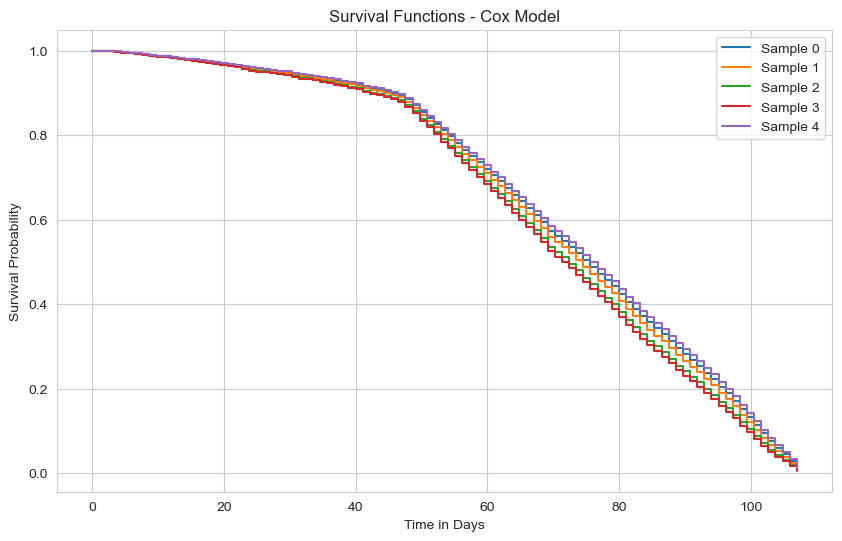

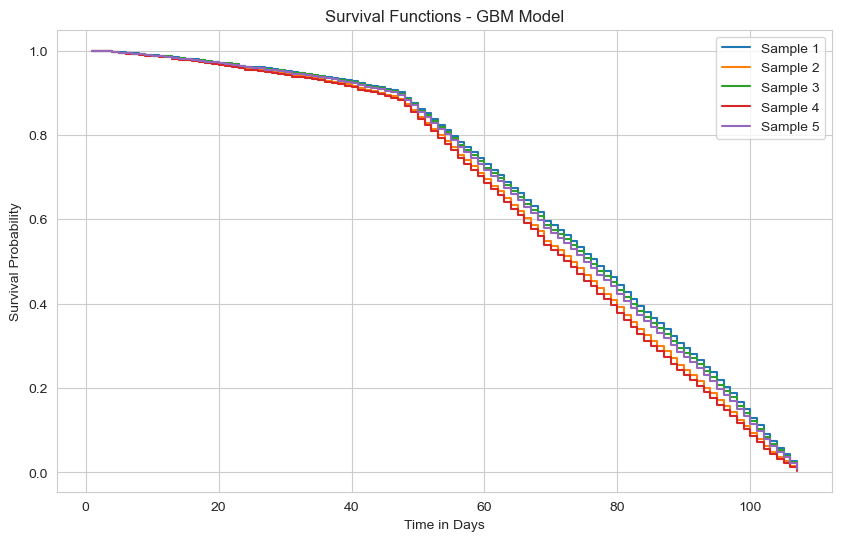

In [21]:
cox_survival_functions = cox_model.predict_survival_function(test_data, times=np.linspace(0, test_data['time'].max(), 100))
gbm_survival_functions = gbm_model.predict_survival_function(X_test, return_array=False)


def plot_cox_survival_functions(survival_functions):
    plt.figure(figsize=(10, 6))
    for col in survival_functions.columns[:5]: 
        plt.step(survival_functions.index, survival_functions[col], where="post", label=f"Sample {col}")
    plt.title("Survival Functions - Cox Model")
    plt.ylabel("Survival Probability")
    plt.xlabel("Time in Days")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cox_survival_functions(cox_survival_functions)

def plot_gbm_survival_functions(survival_functions):
    plt.figure(figsize=(10, 6))
    for i, surv_func in enumerate(survival_functions[:5]):  # Plot first 5 survival functions
        plt.step(surv_func.x, surv_func.y, where="post", label=f"Sample {i+1}")
    plt.title("Survival Functions - GBM Model")
    plt.ylabel("Survival Probability")
    plt.xlabel("Time in Days")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_gbm_survival_functions(gbm_survival_functions)